In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

%load_ext tensorboard

# Neural Network Training


## Load Dataset

In [44]:
data = pd.read_csv('features.csv', header=None).T
data.columns = ['Clump thickness', 'Uniformity of cell size', 'Uniformity of cell shape', 'Marginal adhesion', 'Single epithelial cell size', 'Bare nuclei', 'Bland chomatin', 'Normal nucleoli', 'Mitoses']
labels = pd.read_csv('targets.csv', header=None).T
labels.columns = ['Benign', 'Malignant']
data.describe()

,Clump thickness,Uniformity of cell size,Uniformity of cell shape,Marginal adhesion,Single epithelial cell size,Bare nuclei,Bland chomatin,Normal nucleoli,Mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,0.441774,0.313448,0.320744,0.280687,0.321602,0.354363,0.343777,0.286695,0.158941
std,0.281574,0.305146,0.297191,0.285538,0.221430,0.360186,0.243836,0.305363,0.171508
min,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
25%,0.200000,0.100000,0.100000,0.100000,0.200000,0.100000,0.200000,0.100000,0.100000
50%,0.400000,0.100000,0.100000,0.100000,0.200000,0.100000,0.300000,0.100000,0.100000
75%,0.600000,0.500000,0.500000,0.400000,0.400000,0.500000,0.500000,0.400000,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
def get_model(hidden_layers=2, activation='sigmoid'):
    layers = [tf.keras.layers.InputLayer(input_shape=(9,))] + [
        tf.keras.layers.Dense(9, activation=activation)
        for _ in range(hidden_layers - 1)
    ] + [tf.keras.layers.Dense(2, activation=activation)]

    model = tf.keras.models.Sequential(layers)
    return model

## Split Dataset

Using a 50/50 split, maybe use stratification?

In [21]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, random_state=70)

## Define Model

Variable number of hidden layers. All using 9D outputs except the last layer which is 2D for binary classification

In [46]:
hidden_layers = 9

model = get_model(hidden_layers)
model.compile(tf.optimizers.SGD(), loss='BinaryCrossentropy')
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_118 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_119 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_120 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_121 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_122 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_123 (Dense)            (None, 9)               

# Train Model

Example 10 epochs

In [47]:
model.fit(data_train, labels_train, epochs=10)

Epoch 1/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6393
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6428
Epoch 3/10
11/11 [==============================] - 0s 1ms/step - loss: 0.6519
Epoch 4/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6451
Epoch 5/10
11/11 [==============================] - 0s 1ms/step - loss: 0.6403
Epoch 6/10
11/11 [==============================] - 0s 1ms/step - loss: 0.6371
Epoch 7/10
11/11 [==============================] - 0s 1ms/step - loss: 0.6461
Epoch 8/10
11/11 [==============================] - 0s 1ms/step - loss: 0.6620
Epoch 9/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6497
Epoch 10/10
11/11 [==============================] - 0s 1ms/step - loss: 0.6439


In [48]:
model.metrics[0].result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6451795>

# Experiment 1

In [83]:
hidden_layers = [2, 8, 32]
epochs = [1, 2, 4, 8, 16, 32, 64]

results = list()
for hl in hidden_layers:
    for e in epochs:
        model = get_model(hl)
        model.compile(
            optimizer = tf.optimizers.SGD(),
            loss='BinaryCrossentropy',
            metrics=['Precision']
            )
        model.fit(data_train, labels_train, epochs=e, verbose=0)
        results.append(model.evaluate(data_test, labels_test, batch_size=128))

3/3 [==============================] - 0s 6ms/step - loss: 0.6449 - precision: 0.6543


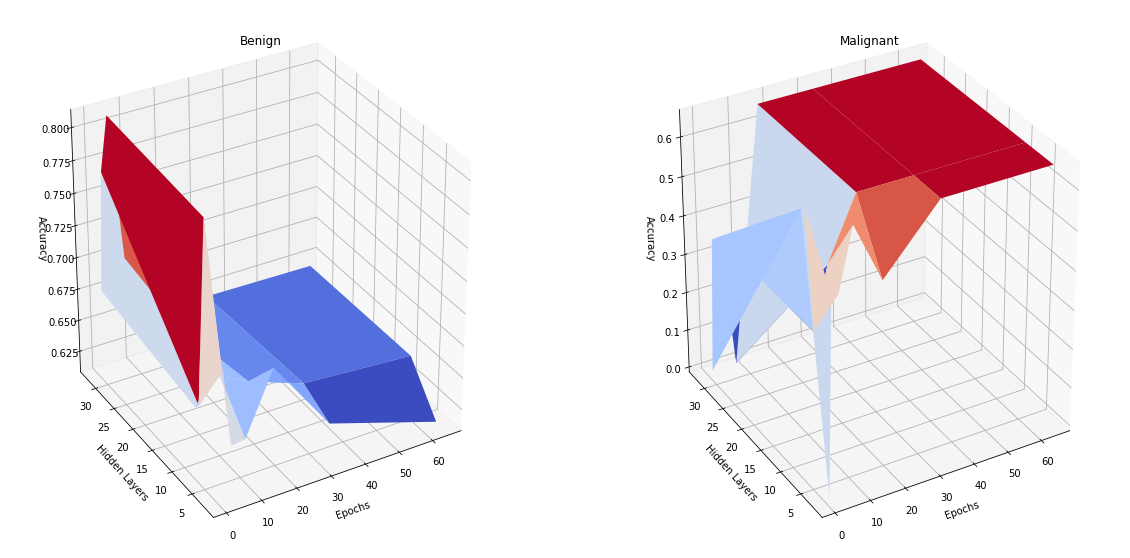

In [89]:
X, Y = np.meshgrid(epochs, hidden_layers)

fig = plt.figure(figsize=(20,10))

for i in [0, 1]:

    result = [r[i] for r in results]
    shaped_result = np.reshape(result, (len(hidden_layers), len(epochs)))

    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, shaped_result, cmap=mpl.cm.coolwarm)
    ax.set_title(labels.columns[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Hidden Layers')
    ax.set_zlabel('Accuracy')
    ax.view_init(30, -120)

# fig.colorbar(surf, shrink=0.3, aspect=6)
plt.show()